In [ ]:
import os
import matplotlib.pyplot as plt

In [6]:
os.getcwd()

'c:\\Users\\Kanishka\\OneDrive\\Desktop\\AI_DermalScan'

In [2]:
dataset = './Dataset'
class_num = 1
labels = []
counts = []
for classes in os.listdir(dataset):
    class_path = os.path.join(dataset, classes)
    labels.append(classes)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        counts.append(num_images)
        print(f'Class {class_num}')
        print(f'Class: {classes}')
        print(f'Number of images: {num_images}')
        print('-----------------------')
        class_num += 1
        

Class 1
Class: clear skin
Number of images: 300
-----------------------
Class 2
Class: dark spots
Number of images: 300
-----------------------
Class 3
Class: puffy eyes
Number of images: 300
-----------------------
Class 4
Class: wrinkles
Number of images: 300
-----------------------


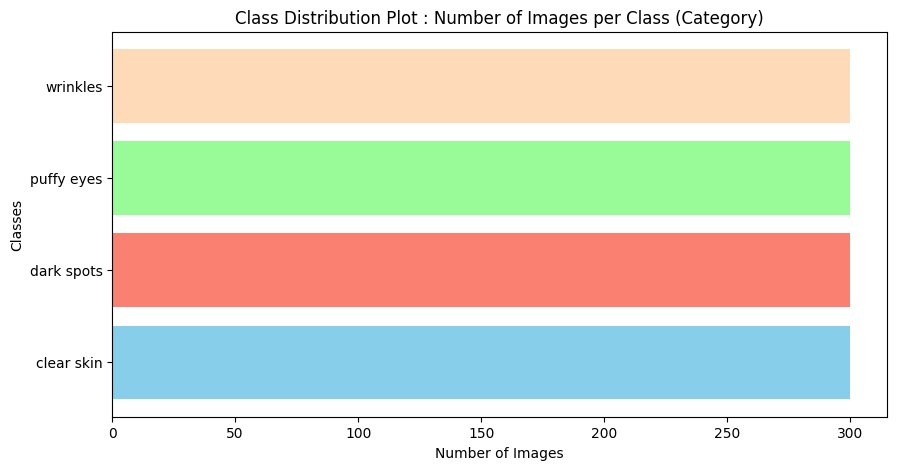

<Figure size 640x480 with 0 Axes>

In [4]:
plt.figure(figsize=(10,5))
plt.barh(labels, counts,color=('skyblue','salmon','palegreen','peachpuff'))
plt.title('Class Distribution Plot : Number of Images per Class (Category)')
plt.xlabel('Number of Images')
plt.ylabel('Classes')
plt.show()
plt.savefig('Class_Distribution_Plot.png')
